In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import geopandas as gpd
import time
from math import sqrt
import pandas as pd
pd.set_option('precision', 10)
%matplotlib inline

In [2]:
import street_network_functions as snf
import utilities as uf

In [3]:
import shapely.geometry
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping, MultiLineString
from shapely.ops import nearest_points

In [4]:
city_name = 'London'
folder_ouptut ='Outputs/'+city_name+'/'
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

In [5]:
from importlib import reload
# reload(uf)

In [6]:
streets_gdf = gpd.read_file(folder_ouptut+city_name+'_paths.shp', driver='ESRI Shapefile')
polygon = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/Congestion_area_polygon/Polygon.shp').to_crs(epsg=epsg)

In [253]:
trajectories1 = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Trajectories/GPSIES/track_points_1.shp').to_crs(epsg=epsg)
trajectories2 = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Trajectories/GPSIES/track_points_2.shp').to_crs(epsg=epsg)
trajectories3 = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Trajectories/GPSIES/track_points_3.shp').to_crs(epsg=epsg)

In [346]:
trajectories4 = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Trajectories/OSM/track_points_5.shp').to_crs(epsg=epsg)

In [254]:
area_to_clip = polygon.loc[0].geometry.buffer(200)

In [347]:
trajectories1 = trajectories1[trajectories1.geometry.within(area_to_clip)]
trajectories2 = trajectories2[trajectories2.geometry.within(area_to_clip)]
trajectories3 = trajectories3[trajectories3.geometry.within(area_to_clip)]
trajectories4 = trajectories4[trajectories4.geometry.within(area_to_clip)]

In [348]:
trajectories4['t'] = trajectories4['time'].str.slice(start = 11, stop=19)
trajectories4 = trajectories4.sort_values(['track_fid', 'track_se_1']).reset_index(drop = True)
trajectories4['seconds'] = ((trajectories4['t'].str.slice(start = 0, stop = 2).astype(int))*3600
                            + (trajectories4['t'].str.slice(start = 3, stop = 5).astype(int))*60
                            + (trajectories4['t'].str.slice(start = 6, stop = 8).astype(int)))
trajectories4.head()

,track_fid,track_seg_,track_se_1,time,type,geometry,t,seconds
0,18,0,0,2018/06/14 06:53:43.000,None,POINT Z (532998.1253076695 180162.966073447 -4...,06:53:43,24823
1,18,0,1,2018/06/14 06:53:44.000,None,POINT Z (532998.1253076695 180162.966073447 -4...,06:53:44,24824
2,18,0,2,2018/06/14 06:53:45.000,None,POINT Z (532998.1253076695 180162.966073447 -4...,06:53:45,24825
3,18,0,3,2018/06/14 06:53:46.000,None,POINT Z (532998.1253076695 180162.966073447 -4...,06:53:46,24826
4,18,0,4,2018/06/14 06:53:47.000,None,POINT Z (533003.7819064826 180161.2334580324 -...,06:53:47,24827


In [ ]:
trajectories4['speed'] = 0.0
previous_fid = None

index_fid = trajectories4.columns.get_loc("track_fid")+1
index_geometry = trajectories4.columns.get_loc("geometry")+1
index_seconds = trajectories4.columns.get_loc("seconds")+1

for row in trajectories4.itertuples():
   
    if previous_fid == None:
        trajectories4.set_value(row[0], 'speed', 1)
        previous_fid = row[index_fid]
        previous_index = row[0]
        continue
    
    if previous_fid != row[index_fid]:
        trajectories4.set_value(row[0], 'speed', 1)
        previous_fid = row[index_fid]
        previous_index = row[0]
        continue
        
    geo = row[index_geometry]
    previous_geometry = trajectories4.loc[previous_index].geometry
    if geo == previous_geometry:
        trajectories4.drop(row[0], axis = 0, inplace = True)
        continue
        
    distance = geo.distance(trajectories4.loc[previous_index].geometry)
    time_span = row[index_seconds] - trajectories4.loc[previous_index].seconds
    if time_span == 0: time_span = 0.01
    speed = float(distance)/float(time_span)
    previous_index = row[0]
    previous_fid = row[index_fid]
    trajectories4.set_value(row[0], 'speed', speed)

In [369]:
check = trajectories4.groupby(['track_fid'])['speed'].mean().reset_index(name = 'speed')
to_keep = check[check.speed > 1]
trajectories4_ped = trajectories4[trajectories4['track_fid'].isin(to_keep.track_fid.values.tolist())]
len(trajectories4_ped)

In [375]:
trajectories4_ped.head()

,track_fid,track_seg_,track_se_1,time,type,geometry,t,seconds,speed
0,18,0,0,2018/06/14 06:53:43.000,None,POINT Z (532998.1253076695 180162.966073447 -4...,06:53:43,24823,1.0000000000
4,18,0,4,2018/06/14 06:53:47.000,None,POINT Z (533003.7819064826 180161.2334580324 -...,06:53:47,24827,1.4790002178
12,18,0,12,2018/06/14 06:53:55.000,None,POINT Z (533005.1669745452 180161.3809764051 -...,06:53:55,24835,0.1741127153
13,18,0,13,2018/06/14 06:53:56.000,None,POINT Z (533004.79396633 180161.3044494962 -46...,06:53:56,24836,0.3807774894
14,18,0,14,2018/06/14 06:53:57.000,None,POINT Z (533006.2638219115 180159.2731204225 -...,06:53:57,24837,2.5073438608


In [381]:
trajectories4_ped.to_file('Outputs/tmp/'+city_name+'_pedestrians_trajOSM.shp', driver='ESRI Shapefile')

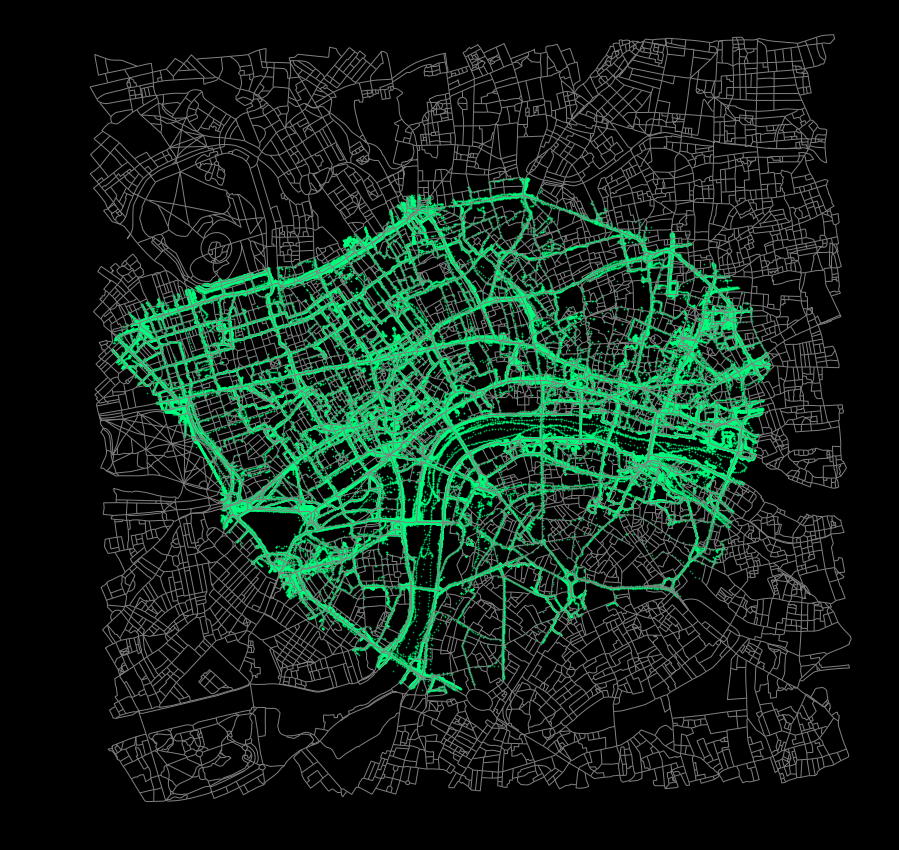

In [380]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax.set_axis_off()

trajectories1.plot(ax=ax, markersize = 0.75, color = 'springgreen', alpha=0.5)
trajectories2.plot(ax=ax, markersize = 0.75, color = 'springgreen', alpha=0.5)
trajectories3.plot(ax=ax, markersize = 0.75, color = 'springgreen', alpha=0.5)
trajectories4_ped.plot(ax=ax, markersize = 0.75, color = 'springgreen', alpha=0.5)
street_gdf.plot(ax=ax, linewidth = 1, color = 'grey')
plt.axis('equal')
plt.rcParams['figure.facecolor'] = 'black'

In [377]:
trajectories1['trajID'] = '1-'+trajectories1.track_fid.astype(str)
trajectories2['trajID'] = '2-'+trajectories2.track_fid.astype(str)
trajectories3['trajID'] = '3-'+trajectories3.track_fid.astype(str)
trajectories4_ped['trajID'] = '4-'+trajectories4_ped.track_fid.astype(str)

In [379]:
traj = pd.concat([trajectories1, trajectories2, trajectories3])
traj = traj[['trajID', 'geometry']]
traj.head()

,trajID,geometry
0,1-0,POINT Z (531638.1245004772 181175.7136688835 -...
1,1-0,POINT Z (531638.009747383 181172.6394184963 -2...
2,1-0,POINT Z (531699.7909919732 181173.1273892745 -...
3,1-0,POINT Z (531792.0421538057 181149.9250928523 -...
4,1-0,POINT Z (531858.3041784283 181138.290634157 -1...


In [383]:
trajectories4_slim = trajectories4_ped[['trajID', 'geometry']]

In [384]:
traj = pd.concat([traj, trajectories4_slim])
traj.reset_index(inplace=True, drop = True)

In [407]:
traj.to_file('Outputs/tmp/'+city_name+'_points_traj.shp', driver = 'ESRI Shapefile')

In [8]:
traj = gpd.read_file('Outputs/tmp/'+city_name+'/'+city_name+'_points_traj.shp').to_crs(epsg=epsg)

In [19]:
traj.head()

,trajID,id_closest,geometry
0,1-0,345,POINT (531638.1245006039 181175.7136683861)
1,1-0,345,POINT (531638.0097475096 181172.6394179996)
2,1-0,344,POINT (531699.7909921003 181173.1273887765)
3,1-0,341,POINT (531792.0421539331 181149.9250923514)
4,1-0,340,POINT (531858.304178556 181138.290633656)


In [24]:
int(streets_gdf.loc[8261].natural_id)

2015

In [25]:
sindex = streets_gdf.sindex
traj['id_closest'] = 0
traj['naturalID'] = 0
index_geometry = traj.columns.get_loc("geometry")+1
index_geometry_l = streets_gdf.columns.get_loc("geometry")+1

for row in traj.itertuples():
    geo = row[index_geometry]
    geo_buff = geo.buffer(150)
    possible_matches_index = list(sindex.intersection(geo_buff.bounds))
    possible_matches = streets_gdf.iloc[possible_matches_index]
    precise_matches  = possible_matches[possible_matches.intersects(geo_buff)]
    if(len(precise_matches) == 0): 
        traj.drop(row[0], axis = 0, inplace = True)
        continue
    distances = [(rowC[0], rowC[index_geometry_l].distance(geo)) for rowC in precise_matches.itertuples()]
    index = min(distances, key = lambda item:item[1])[0]
    traj.set_value(row[0], 'id_closest', index)
    nID = int(streets_gdf.loc[index].natural_id)
    traj.set_value(row[0], 'naturalID', nID)

In [10]:
minimum = 6
grouped = traj.groupby(['id_closest', 'trajID']).size().reset_index(name = 'counts')
grouped = grouped[grouped.counts > minimum]
values = grouped.groupby(['id_closest']).size().reset_index(name = 'counts')
values.head()

,id_closest,counts
0,0,31
1,3,1
2,6,1
3,7,2
4,8,1


In [11]:
streets_gdf = pd.merge(streets_gdf, values[['id_closest','counts']], how= 'left', left_index = True, right_on = "id_closest")
streets_gdf.reset_index(drop = True, inplace = True)

In [12]:
streets_gdf['counts'].fillna(0, inplace = True)
streets_gdf.drop('id_closest', axis = 1, inplace = True)
streets_gdf.head()

,streetID,length,highway,name,v,u,key,Eb,Erw,Ab,natural_id,length_sc,geometry,counts
0,27,61.9609935961,unclassified,York Gate,13539,12971,0,1434.0,74249.1948533131,12302.0,5757,0.1245263601,LINESTRING (528256.7304999996 182141.096400000...,31.0
1,30,43.0651889559,trunk,Marylebone Road,13515,11,0,1126328.0,532870.3345246799,2358545.0,6367,0.0864537589,LINESTRING (528303.8957000002 182074.120400000...,0.0
2,31,39.8456146227,unclassified,York Gate,1012,11,0,12727.0,493457.0319978174,667513.0,8646,0.0799667332,LINESTRING (528303.8957000002 182074.120400000...,0.0
3,32,61.5192282462,trunk,Marylebone Road,432,11,0,1153328.0,526718.5420527948,2995426.0,6367,0.1236362601,LINESTRING (528303.8957000002 182074.120400000...,1.0
4,119,17.8318237145,primary,Portland Place,11697,43,0,287730.0,273572.8944622917,457488.0,1674,0.0356117931,LINESTRING (528704.1456000004 182068.777100000...,0.0


In [13]:
len(traj.trajID.unique())

653

In [14]:
streets_gdf['rel_count'] = streets_gdf['counts']/len(traj.trajID.unique())*100
streets_gdf.head()

,streetID,length,highway,name,v,u,key,Eb,Erw,Ab,natural_id,length_sc,geometry,counts,rel_count
0,27,61.9609935961,unclassified,York Gate,13539,12971,0,1434.0,74249.1948533131,12302.0,5757,0.1245263601,LINESTRING (528256.7304999996 182141.096400000...,31.0,4.7473200613
1,30,43.0651889559,trunk,Marylebone Road,13515,11,0,1126328.0,532870.3345246799,2358545.0,6367,0.0864537589,LINESTRING (528303.8957000002 182074.120400000...,0.0,0.0000000000
2,31,39.8456146227,unclassified,York Gate,1012,11,0,12727.0,493457.0319978174,667513.0,8646,0.0799667332,LINESTRING (528303.8957000002 182074.120400000...,0.0,0.0000000000
3,32,61.5192282462,trunk,Marylebone Road,432,11,0,1153328.0,526718.5420527948,2995426.0,6367,0.1236362601,LINESTRING (528303.8957000002 182074.120400000...,1.0,0.1531393568
4,119,17.8318237145,primary,Portland Place,11697,43,0,287730.0,273572.8944622917,457488.0,1674,0.0356117931,LINESTRING (528704.1456000004 182068.777100000...,0.0,0.0000000000


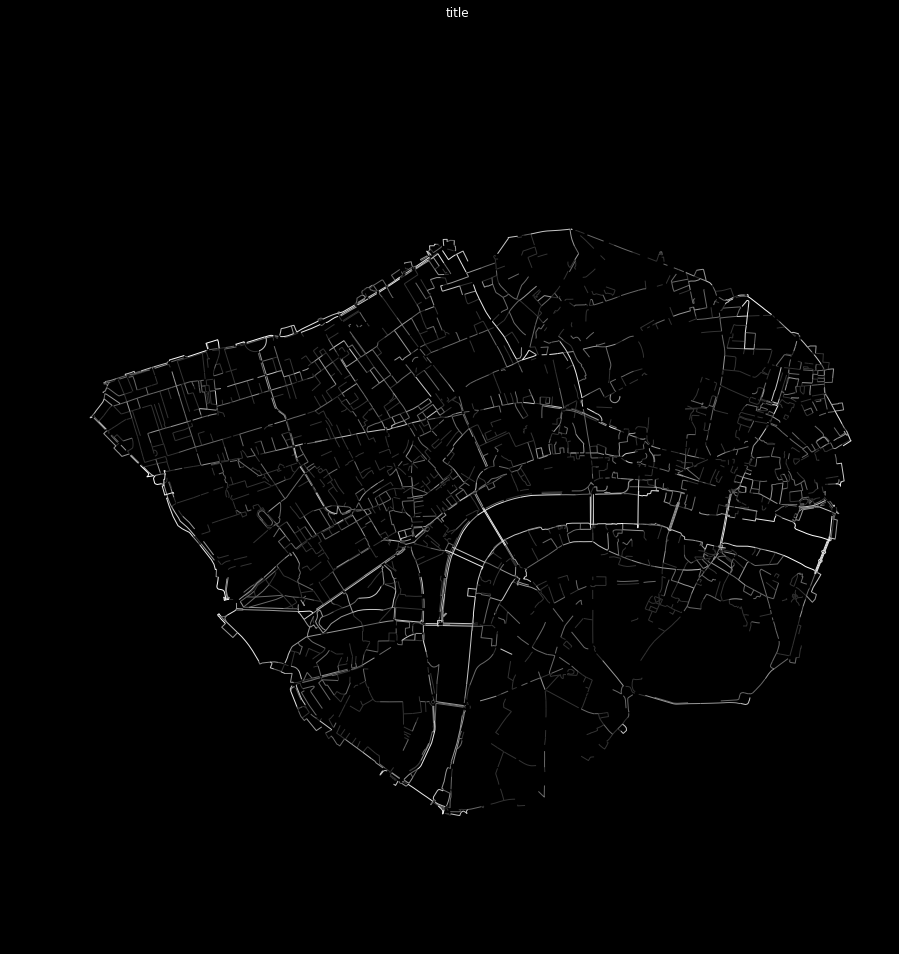

In [16]:
uf.plot_lines(streets_gdf, classes = 7, lw = 1, column = 'counts', title = 'title', scheme = 'fisher_jenks', cmap = 'Greys_r')

In [17]:
streets_gdf.to_file('Outputs/tmp/'+city_name+'/'+city_name+'_counts_od.shp', driver='ESRI Shapefile')